In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import glob

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

from argparse import Namespace

In [3]:
from utils import *
from pca import CustomPCA
from fa import CustomFactorAnalysis as CustomFA

In [4]:
HOME = os.getcwd()
DATA = os.path.join(HOME, '..', 'data')
FIGS = os.path.join(HOME, '..', 'figs')
calib_mode = 'hats'

# stage 1
p1df = pd.read_csv('../data/p1tha.csv').set_index('PAQ')

# stage 2 listening test
p2df = load_data(DATA, calib_mode)

# stage 2 demographics
p2df_paq = pd.read_excel(os.path.join(DATA, 'paq', 'paq_240123.xlsx'))

# stage 2 english
p2dfeng = pd.read_excel(os.path.join(DATA, "eng UCL.xlsx"))

# satp demographics
df_satp = pd.read_excel(os.path.join(DATA,'SATP Dataset v1.4.xlsx'))

In [5]:
sns.set_theme('paper', 'whitegrid')

In [6]:
def define_latex_command(name, value, value_format=None):
    
    if value_format is not None:
        if type(value_format) is str:
            value = value_format.format(value)
        else:
            value = value_format(value)
    
    nc = "\\newcommand{\\" + name + "}{" + value + "}"
    
    return nc

# Demographic Information

## Thai

In [7]:
df = p2df_paq.copy()
failed_hearing = [7, 27]
df = df[~df['Participant ID'].isin(failed_hearing)]

q_age = 'What is your age?'
q_gender ='What is your gender?'

df = df.rename(columns={q_age: 'age', q_gender: 'gender'})

distr = df.groupby('gender')['age'].describe(include="all")
distr.loc["Total"] = df['age'].describe().T

distr["count%"] = 100 * distr["count"]/distr.loc["Total", "count"]

distr = distr[["count", "count%", "mean", "std", "min", "50%", "max"]]

df_tha_age = df.copy()

In [8]:
def demo_to_table(demo):
    demo["count"] = demo["count"].astype(int)
    
    demo["cc"] = demo.apply(
        lambda r: f"{r['count']:1.0f}" + r" & (\SI{" + f"{r['count%']:1.0f}" + r"}{\percent})",
        axis=1
    )
    
    print(demo[["cc", "mean", "std", "min", "50%", "max"]].reset_index(False).to_latex(float_format="%2.1f", index=False, escape=False))

In [9]:
demo_to_table(distr)

\begin{tabular}{llrrrrr}
\toprule
gender & cc & mean & std & min & 50% & max \\
\midrule
Female & 12 & (\SI{48}{\percent}) & 30.8 & 10.0 & 18.0 & 27.5 & 51.0 \\
Male & 13 & (\SI{52}{\percent}) & 26.2 & 9.0 & 18.0 & 25.0 & 50.0 \\
Total & 25 & (\SI{100}{\percent}) & 28.4 & 9.6 & 18.0 & 27.0 & 51.0 \\
\bottomrule
\end{tabular}



## Kolmogorov-Smirnov

In [10]:
from scipy.stats import kstest

In [11]:
df = df_satp.copy()

df = df[df['Language'] == "eng"]
df['Age'] = df['Age'].astype(float)
df = df.groupby("Participant")[["Age", "Gender"]].first()
df = df.rename(columns={c: c.lower() for c in df.columns})

df_eng_age = df.copy()

In [12]:
distr = df.groupby('gender')['age'].describe(include="all")
distr.loc["Total"] = df['age'].describe().T

distr["count%"] = 100 * distr["count"]/distr.loc["Total", "count"]

distr = distr[["count", "count%", "mean", "std", "min", "50%", "max"]]

In [13]:
kstest(df_eng_age["age"], df_tha_age["age"])

KstestResult(statistic=0.24875, pvalue=0.28508098234686857)

## English

In [14]:
demo_to_table(distr)

\begin{tabular}{llrrrrr}
\toprule
gender & cc & mean & std & min & 50% & max \\
\midrule
Female & 13 & (\SI{41}{\percent}) & 29.3 & 7.6 & 21.0 & 26.0 & 43.0 \\
Male & 19 & (\SI{59}{\percent}) & 29.9 & 7.3 & 22.0 & 28.0 & 47.0 \\
Total & 32 & (\SI{100}{\percent}) & 29.7 & 7.3 & 21.0 & 27.0 & 47.0 \\
\bottomrule
\end{tabular}



# Reliability Check

In [15]:
import pingouin as pg

In [16]:
df = p2df.copy()

### ICC Table

In [17]:
tab = []

iccs = {}

for p in PAQ_CCW:
    
    cols = []
    alph, ci = pg.cronbach_alpha(df, subject='pid', items='stimulus_id', scores=p)
    ic = pg.intraclass_corr(df, raters='pid', ratings=p, targets='stimulus_id').set_index('Type')
    
    cols += [
        f"tha{p.capitalize()}",
        f"{ic.loc['ICC2']['ICC']:.3f}",
        f"[{ic.loc['ICC2']['CI95%'][0]:.3f}, {ic.loc['ICC2']['CI95%'][1]:.3f}]",
        f"{ic.loc['ICC2']['F']:.3f}",
        f"$<$0.001",
        f"{ic.loc['ICC2k']['ICC']:.3f}",
        f"[{ic.loc['ICC2k']['CI95%'][0]:.3f}, {ic.loc['ICC2k']['CI95%'][1]:.3f}]",
        f"{ic.loc['ICC2k']['F']:.3f}",
        f"$<$0.001",
    ]
    tab.append(" & ".join(cols))
    # print(define_latex_command(f"cronbach{p.capitalize()}", alph, "{:.3g}"))

    # print(define_latex_command(f"cronbach{p.capitalize()}cilo", ci[0], "{:.3g}"))
    # print(define_latex_command(f"cronbach{p.capitalize()}cihi", ci[1], "{:.3g}"))
    
    iccs[p] = [ic.loc['ICC2']['ICC'], ic.loc['ICC2k']['ICC']]
    
print("\\\\ \n".join(tab) + "\\\\")

thaPl & 0.571 & [0.440, 0.720] & 42.341 & $<$0.001 & 0.971 & [0.950, 0.980] & 42.341 & $<$0.001\\ 
thaVi & 0.590 & [0.460, 0.730] & 41.750 & $<$0.001 & 0.973 & [0.960, 0.990] & 41.750 & $<$0.001\\ 
thaEv & 0.252 & [0.160, 0.400] & 11.425 & $<$0.001 & 0.894 & [0.830, 0.940] & 11.425 & $<$0.001\\ 
thaCh & 0.571 & [0.440, 0.720] & 44.172 & $<$0.001 & 0.971 & [0.950, 0.980] & 44.172 & $<$0.001\\ 
thaAn & 0.547 & [0.420, 0.700] & 39.817 & $<$0.001 & 0.968 & [0.950, 0.980] & 39.817 & $<$0.001\\ 
thaMo & 0.412 & [0.290, 0.580] & 20.235 & $<$0.001 & 0.946 & [0.910, 0.970] & 20.235 & $<$0.001\\ 
thaUn & 0.256 & [0.160, 0.410] & 11.186 & $<$0.001 & 0.896 & [0.830, 0.940] & 11.186 & $<$0.001\\ 
thaCa & 0.593 & [0.460, 0.740] & 47.907 & $<$0.001 & 0.973 & [0.960, 0.990] & 47.907 & $<$0.001\\


### ICC Figure

In [18]:
for p, (icc2, icc2k) in iccs.items():
    p1df.loc[p, 'ICC2'] = icc2
    p1df.loc[p, 'ICC2k'] = icc2k
    
p1df['isMain'] = p1df.index.isin(['pl', 'an', 'ev', 'un'])

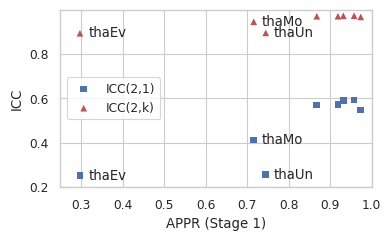

In [19]:
def get_lim(y):
    return max(np.floor(y.min()*20 - 1)/20, 0.0), min(1.0, np.ceil(y.max()*20 + 1)/20)

def p1vsp2(crit):

    f, ax = plt.subplots(figsize=(4, 2.5), tight_layout=True)

    sns.scatterplot(p1df, x=crit,y='ICC2', marker='s', c='b', ax=ax, label='ICC(2,1)', ec="none")
    sns.scatterplot(p1df, x=crit,y='ICC2k', marker='^', c='r', ax=ax, label='ICC(2,k)', ec="none")
    ax.set(ylim=[0.2, 1.0], xlim=[0.25, 1])
    
    for c in ["ICC2", "ICC2k"]:
        for p in ['ev', 'mo', 'un']:
            ax.text(x=p1df.loc[p, crit] + 0.02, y=p1df.loc[p, c], s=f"tha{p.capitalize()}", ha='left', va='center')

    ax.legend(loc="center left")

    ax.set(xlabel=f'{crit} (Stage 1)')
    ax.set(ylabel='ICC')
    
    ax.set(xticks=np.arange(0.3, 1.05, 0.1), yticks=np.arange(0.2, 1, 0.2))
    ax.grid(True, which="both")

    plt.savefig(f'{FIGS}/{crit}_vs_icc.pdf')
    plt.show()
    
p1vsp2("APPR")

# PCA & OPP

In [20]:
from copy import deepcopy

In [21]:
from matplotlib.patches import Circle, RegularPolygon

In [22]:
df = p2df.copy()

In [23]:
def unitary_transform(pca, targets_proj):
    rpca = deepcopy(pca)

    A = rpca.components_[:2, :] @ targets_proj
    B = np.eye(2, 2)  
    M = B @ A.T
    U, S, Vt = np.linalg.svd(M)

    R = U@Vt

    rpca.components_[:2, :] = R @ rpca.components_[:2, :]
    
    return rpca, R

In [24]:
dfx = df.groupby('stimulus_id').mean()    
pca_raw = CustomPCA(n_components=8, whiten=False, center=False)
pca_mean = CustomPCA(n_components=8, whiten=False, center=False)

pca_raw = pca_raw.fit(df[PAQ_CCW])
pca_mean = pca_mean.fit(dfx[PAQ_CCW])

rpca_raw, Rr = unitary_transform(pca_raw, iso_proj)
rpca_mean, Rm = unitary_transform(pca_mean, iso_proj)

for n, pca in [('ur', pca_raw), ('um', pca_mean), ('rr', rpca_raw), ('rm', rpca_mean)]:
    pcm = pca.transform(dfx[PAQ_CCW])/np.sqrt(8)
    pcr = pca.transform(df[PAQ_CCW])/np.sqrt(8)
    for i in range(pca.n_components):
        dfx[f'{n}{i+1}proj'] = pcm[:, i]
        df[f'{n}{i+1}proj'] = pcr[:, i]

### Explained Variances and Cosine Similarity

In [25]:
np.sum(pca_raw.explained_variance_ratio_[:2])

0.8086376732321678

In [26]:
np.sum(pca_mean.explained_variance_ratio_[:2])

0.9441958097009986

In [27]:
def cosine_sim(A, B, feature_axis=-1):
    A = A/np.linalg.norm(A, axis=feature_axis, keepdims=True)
    B = B/np.linalg.norm(B, axis=feature_axis, keepdims=True)
    
    C = np.sum(A*B, axis=feature_axis)
    
    return C

cosine_sim(rpca_raw.components_, rpca_mean.components_)

array([ 0.99805677,  0.96165094,  0.78755704, -0.76499166,  0.66373858,
        0.7740638 ,  0.86821296,  0.98514682])

### Projection Plots

In [28]:
from types import SimpleNamespace

def get_rdirections(proj, compute_iso=False):
    rdirections = {}
    rvec= {}
    for i, p in enumerate(PAQ_CCW):
        dfi = pd.DataFrame({p: [pc_vec(i)[j]] for j, p in enumerate(PAQ_CCW)})
        rvec[p] = proj.transform(dfi)[0, :2]
        x, y = rvec[p]
        rdirections[p] = np.rad2deg(np.arctan2(y, x))

    if compute_iso:
        ipl = iso_pl(SimpleNamespace(**rvec))
        iev = iso_ev(SimpleNamespace(**rvec))
        rvec["isopl"] = ipl
        rvec["isoev"] = iev

        x, y = ipl
        rdirections["isopl"] = np.rad2deg(np.arctan2(y, x))

        x, y = iev
        rdirections["isoev"] = np.rad2deg(np.arctan2(y, x))
        
    return rdirections, rvec

def plot_background(ax, df, dfx, x, y, indiv=False):
    sns.kdeplot(df, x=x, y=y, levels=10, alpha=0.25, ax=ax)
    sns.scatterplot(dfx, x=x, y=y, marker="o", c="red", alpha=0.5,  ax=ax)

    if indiv:
        sns.scatterplot(df, x=x, y=y, marker=".", c="peru", alpha=0.5,  ax=ax)


def plot_in_pc(ax, df, dfx, x, y, proj, k=1.0, kp=2.0, indiv=False):
    plot_background(ax, df, dfx, x, y, indiv=indiv)

    _, rdirections = get_rdirections(proj)

    isopl_in_rpc = norm_norm(iso_pl(Namespace(**rdirections))) 
    isoev_in_rpc = norm_norm(iso_ev(Namespace(**rdirections))) 
    riso_plev = [isopl_in_rpc, isoev_in_rpc]

    for paq, d in rdirections.items():
        ax.annotate("", xy=k*d, xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", ec="black", shrinkA=0, shrinkB=0))
        ax.annotate(paq, xy=k*d, **hava(d, hd="center"))

    for i, p in enumerate(["isoPl", "isoEv"]):
        ax.annotate("", xy=kp*riso_plev[i], xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color="blue", shrinkA=0, shrinkB=0))
        ax.annotate(p, xy=kp*riso_plev[i], **hava(riso_plev[i], vd="center", hd="center"), color="blue")
    
    for rad in [1.0]:
        c = plt.Circle((0, 0), rad, fc="none", ec="black", ls=":", alpha=0.5)
        ax.add_artist(c)

    lim = 1.0
    ax.axis('scaled')
    ax.set(xlim=[-lim, lim], ylim=[-lim, lim]) #, xticklabels=[], yticklabels=[])

In [29]:
def plot_components(ax, proj, color, name, lim,  k=1.0):
    pc_in_paq = proj.inverse_transform(np.stack([pc_vec(i) for i in range(proj.n_components)], axis=1))[:4]
    pc_in_iso = [norm_norm(iso_np(p)) for p in pc_in_paq]

    for i, v in enumerate(pc_in_iso[:lim]):
        ax.annotate("", xy=k*v, xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", 
                                ec=color,
                                alpha=1.0, shrinkA=0, shrinkB=0
                               ))

        ax.annotate(f"{name} {i+1}", xy=k*v, **hava(v, thresh=0.05, hd="right", vd="center"))
        
def plot_in_iso(ax, df, dfx, pca, rpca, k=1.0, lim=1.0, indiv=False):
    plot_background(ax, df, dfx, "isopl", "isoev", indiv=indiv)
    
    plot_components(ax, pca, "blue", "PC", 4, k=k)
    plot_components(ax, rpca, "purple", "RPC", 2, k=k)
    
    for rad in [1.0]:
        c = RegularPolygon((0, 0), 8, radius=rad/np.cos(np.deg2rad(22.5)), orientation=np.deg2rad(67.5), fc="none", ec="black", ls=":", alpha=0.5)
        ax.add_artist(c)
    
    ax.axis('scaled')
    ax.set(xlim=[-lim, lim], ylim=[-lim, lim])

In [30]:
def make_pca_plot(df, dfx, pca, rpca, name, lang, pre):
    
    mode = name[0]
    
    if mode == 'r':
        suffix = f"{pre} Computed from Raw Data: {lang}"
    else:
        suffix = f"{pre} Computed from Participant-Averaged Data: {lang}"
        
    colors = [plt.cm.tab20b(i) for i in range(20)] + [plt.cm.tab20c(i) for i in range(7)]
    cmap = mpl.colors.ListedColormap(colors)

    f, axs = plt.subplots(1, 3, figsize=(12,4))
    
    ax = axs[0]

    lim = 1.5
    
    plot_in_iso(ax, df, dfx,  pca, rpca, k=2, indiv=True)

    ax.set(
        title=f'In the Circumplex Space', 
        xlabel="ISO Pleasantness",
        ylabel="ISO Eventfulness",
    )

     #, xticklabels=[], yticklabels=[])

    ############################################

    ax = axs[1]

    x = f"u{mode}1proj"
    y = f"u{mode}2proj"
    
    plot_in_pc(ax, df, dfx, x, y, pca, indiv=False)

    ax.set(
        title=f"In the Unrotated PC Space",
        xlabel="PC 1",
        ylabel="PC 2"
    )

    ############################################

    ax = axs[2]

    x = f"r{mode}1proj"
    y = f"r{mode}2proj"
    
    plot_in_pc(ax, df, dfx, x, y, rpca, indiv=False)
    
    
    for a in np.deg2rad(np.arange(15, 180, 15)):
        if a == np.pi/2:
            continue
        ax.plot([np.cos(a), np.cos(a + np.pi)], [np.sin(a), np.sin(a + np.pi)],
                ls=":",
            color="gray", alpha=0.5)

    ax.set(
        title=f"In the Rotated PC Space",
        xlabel="RPC 1",
        ylabel="RPC 2"
    )
   
    plt.suptitle(suffix, x=0.515, ha='center')

    plt.tight_layout()
    plt.savefig(f"{FIGS}/pca-{name}-{lang}.pdf")

    plt.show()

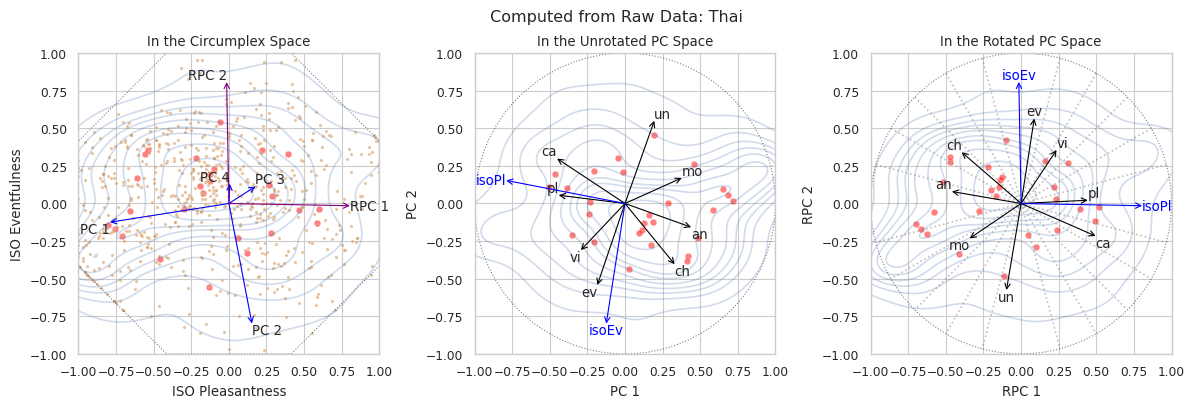

In [31]:
make_pca_plot(df, dfx, pca_raw, rpca_raw, 'raw', "Thai", "")

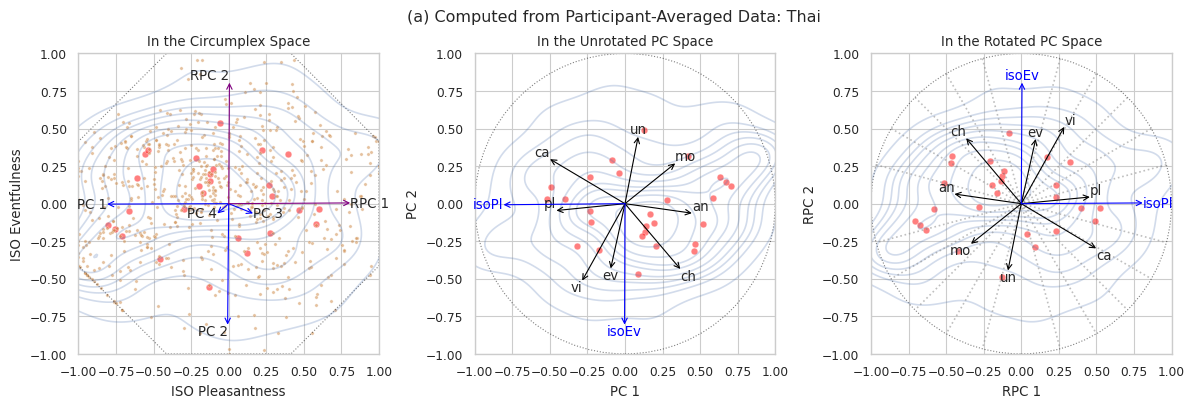

In [32]:
make_pca_plot(df, dfx, pca_mean, rpca_mean, 'mean', "Thai", "(a)")

In [33]:
dfeng = df_satp.copy()

dfeng = dfeng[dfeng.Language == "eng"]

PAQs = [f"PAQ{i+1}" for i in range(8)]
dfeng = dfeng[["Participant", "Recording"] + PAQs]

dfeng = dfeng.rename(columns={
    f"PAQ{i+1}": p for i, p in enumerate(PAQ_CCW)
})

for col in PAQ_CCW:
    dfeng[col] = dfeng[col].apply(normalize_response) #.apply(double_square)
        
dfeng['isopl'] = dfeng.apply(iso_pl, axis=1).apply(norm_norm)
dfeng['isoev'] = dfeng.apply(iso_ev, axis=1).apply(norm_norm)

dfengx = dfeng.groupby("Recording").mean(numeric_only=True).sort_index()

pca_eng = CustomPCA(n_components=8, whiten=False, center=False)
pca_eng = pca_mean.fit(dfengx[PAQ_CCW])

rpca_eng, Rm = unitary_transform(pca_eng, iso_proj)

for n, pca in [('um', pca_eng), ('rm', rpca_eng)]:
    pcm = pca.transform(dfengx[PAQ_CCW])/np.sqrt(6)
    pcr = pca.transform(dfeng[PAQ_CCW])/np.sqrt(6)
    for i in range(pca.n_components):
        dfengx[f'{n}{i+1}proj'] = pcm[:, i]
        dfeng[f'{n}{i+1}proj'] = pcr[:, i]

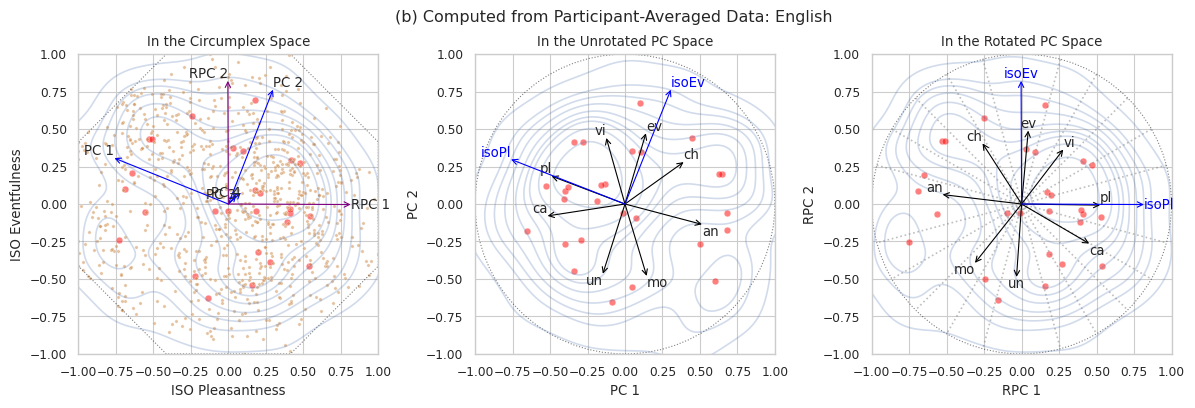

In [34]:
make_pca_plot(dfeng, dfengx, pca_eng, rpca_eng, 'mean', "English", "(b)")

In [35]:
 from iso639 import languages

In [36]:
run_this = False

if run_this:
    
    for (lang,), dfzsm in df_satp.copy().groupby(["Language",]):
        dfzsm = dfzsm[(dfzsm.Language == lang)]# & (dfzsm.Institution == inst)]
        
        PAQs = [f"PAQ{i+1}" for i in range(8)]
        dfzsm = dfzsm[["Participant", "Recording"] + PAQs]
    
        dfzsm = dfzsm.dropna(subset=PAQs)
        
        dfzsm = dfzsm.rename(columns={
            f"PAQ{i+1}": p for i, p in enumerate(PAQ_CCW)
        })
        
        for col in PAQ_CCW:
            dfzsm[col] = dfzsm[col].apply(normalize_response) #.apply(double_square)
                
        dfzsm['isopl'] = dfzsm.apply(iso_pl, axis=1).apply(norm_norm)
        dfzsm['isoev'] = dfzsm.apply(iso_ev, axis=1).apply(norm_norm)
        
        dfzsmx = dfzsm.groupby("Recording").mean(numeric_only=True).sort_index()
        
        pca_eng = CustomPCA(n_components=8, whiten=False, center=False)
        pca_eng = pca_mean.fit(dfzsmx[PAQ_CCW])
        
        rpca_eng, Rm = unitary_transform(pca_eng, iso_proj)
        
        for n, pca in [('um', pca_eng), ('rm', rpca_eng)]:
            pcm = pca.transform(dfzsmx[PAQ_CCW])/np.sqrt(6)
            pcr = pca.transform(dfzsm[PAQ_CCW])/np.sqrt(6)
            for i in range(pca.n_components):
                dfzsmx[f'{n}{i+1}proj'] = pcm[:, i]
                dfzsm[f'{n}{i+1}proj'] = pcr[:, i]
    
        ln = languages.get(part3=lang).name
    
        if "Greek" in ln:
            ln = "Modern Greek"
    
        make_pca_plot(dfzsm, dfzsmx, pca_eng, rpca_eng, 'mean', f"{ln} ({lang})", "")

# Angular Analysis

In [45]:
tha_,_  = get_rdirections(rpca_mean, True)
eng_, _ = get_rdirections(rpca_eng, True)

tha = {f'tha{k.capitalize()}': v for k, v in tha_.items() if k in PAQ_CCW}
eng = {f'eng{k.capitalize()}': v for k, v in eng_.items() if k in PAQ_CCW}

thaIdx = pd.CategoricalDtype([f'tha{k.capitalize()}' for k in PAQ_CCW])
engIdx = pd.CategoricalDtype([f'eng{k.capitalize()}' for k in PAQ_CCW])

dfrs = []

for lang, idx in [(tha, thaIdx), (eng, engIdx)]:
    dfr = pd.DataFrame({'loc': lang})
    dfr.index = dfr.index.astype(idx)
    dfr = dfr.sort_index()
    dfr["theo"] = np.rad2deg(np.arctan2(iso_proj[:, 1], iso_proj[:, 0])).astype(int)
    langloc = dfr['loc'].values
    dfr['dev'] = dfr['loc'] - dfr['theo']
    dfr[f'adj-ccw'] = -np.mod(langloc - np.roll(langloc, -1), -360)
    dfr[f'adj-cw'] = np.mod(langloc - np.roll(langloc, 1), 360)
    
    dfr[f'orth-ccw'] = -np.mod(langloc - np.roll(langloc, -2), -360)
    dfr[f'orth-cw'] = np.mod(langloc - np.roll(langloc, 2), 360)
    dfr[f'anti'] = np.abs(langloc - np.roll(langloc, 4))
    dfr[f'anti'] = np.minimum(dfr[f'anti'], 360-dfr[f'anti'])
    
    dfrc = dfr.columns
    dfrc = ['theo'] + [c for c in dfrc if c != 'theo']
    
    
    dfrs.append(dfr[dfrc])
    
dfr = pd.concat(dfrs)

In [40]:
print(dfr.to_latex(float_format="%-3.1f"))

\begin{tabular}{lrrrrrrrr}
\toprule
 & theo & loc & dev & adj-ccw & adj-cw & orth-ccw & orth-cw & anti \\
\midrule
thaPl & 0 & 5.6 & 5.6 & 55.2 & 36.4 & 71.9 & 106.8 & 166.2 \\
thaVi & 45 & 60.8 & 15.8 & 16.7 & 55.2 & 69.4 & 91.6 & 157.8 \\
thaEv & 90 & 77.4 & -12.6 & 52.7 & 16.7 & 94.4 & 71.9 & 178.7 \\
thaCh & 135 & 130.1 & -4.9 & 41.7 & 52.7 & 88.5 & 69.4 & 161.0 \\
thaAn & 180 & 171.8 & -8.2 & 46.8 & 41.7 & 87.0 & 94.4 & 166.2 \\
thaMo & -135 & -141.4 & -6.4 & 40.1 & 46.8 & 110.5 & 88.5 & 157.8 \\
thaUn & -90 & -101.3 & -11.3 & 70.4 & 40.1 & 106.8 & 87.0 & 178.7 \\
thaCa & -45 & -30.9 & 14.1 & 36.4 & 70.4 & 91.6 & 110.5 & 161.0 \\
engPl & 0 & -0.8 & -0.8 & 53.4 & 29.5 & 85.7 & 93.2 & 174.0 \\
engVi & 45 & 52.6 & 7.6 & 32.2 & 53.4 & 70.2 & 82.9 & 179.0 \\
engEv & 90 & 84.8 & -5.2 & 38.0 & 32.2 & 88.4 & 85.7 & 178.8 \\
engCh & 135 & 122.8 & -12.2 & 50.4 & 38.0 & 108.8 & 70.2 & 153.2 \\
engAn & 180 & 173.2 & -6.8 & 58.4 & 50.4 & 92.8 & 88.4 & 174.0 \\
engMo & -135 & -128.4 & 6.6 & 34.

In [42]:
tha_["isopl"], tha_["isoev"]

(0.35145685157179335, 89.64708693656324)

In [43]:
eng_["isopl"], eng_["isoev"]

(-0.2390381397455881, 90.23741718084113)

# By Stimulus

In [ ]:
df = p2df.copy()

In [ ]:
def stim2filename(s):
    fnames = ['CG01', 'CG04', 'CT301', 'E01b', 'E02', 'E05', 'E09', 'CG07', 'E11b', 'E12b', 'E10', 'HR01', 'KT01', 'LS06', 'N1', 'OS01c', 'OS01d', 'RPJ01', 'VP01b', 'W01', 'W06', 'W09', 'W11a', 'W15', 'W16', 'W22', 'W23a']
    return fnames[int(s)-1]

df['Recording'] = df['stimulus_id'].apply(stim2filename)

In [ ]:
import math

ncol = 5
nrow = math.ceil(27 / ncol)

f, axs = plt.subplots(nrow, ncol, figsize=(8, 10))
for i in range(3):
    f.delaxes(axs[-1][-(i+1)])
    
for i, (s, dfg) in enumerate(df.groupby('Recording')):
    
    r = i // ncol
    c = i % ncol
    sns.kdeplot(dfg, x='isopl', y='isoev', levels=[0.1, 0.25, 0.5, 0.75, 0.9, 1.0], fill=True, ax=axs[r,c], color="gray", clip=(-1,1), alpha=0.5)
    sns.scatterplot(dfg, x='isopl', y='isoev', ax=axs[r,c], color="blue", marker='.')
    x, y = dfg[['isopl', 'isoev']].mean().values
    axs[r,c].plot(x, y, color="green", marker='s', label='Thai')
    
    if y < 0.0 and not (r == 4 and c == 3):
        yy = 0.75
    else:
        yy = 0.0
    
        
    axs[r, c].set_title(s, y=yy)
    axs[r, c].set(
        xlim=[-1, 1], 
        ylim=[-1, 1],
        xticks=np.linspace(-1, 1, 9),
        yticks=np.linspace(-1, 1, 9),
        xlabel=None,
        ylabel=None,
        xticklabels=[],
        yticklabels=[]
    )
    axs[r, c].set_aspect('equal')
    axs[r, c].tick_params(direction="in")
    
axs[5, 1].yaxis.set_ticks_position("right")
axs[5, 1].yaxis.set_label_position("right")
axs[5, 1].set(ylabel="isoEv")
axs[5, 1].set(yticklabels=[-1, None, -0.5, None, 0, None, 0.5, None, 1])

axs[4, 3].set(xlabel="isoPl")
axs[4, 3].xaxis.set_ticks_position("bottom")
axs[4, 3].set(xticklabels=[-1, None, -0.5, None, 0, None, 0.5, None, 1])
    
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(f"{FIGS}/perstim.pdf", dpi=600, bbox_inches="tight")

### t-Tests

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
df

In [ ]:
tha_data = np.stack(df.sort_values("Recording").groupby("Recording").apply(lambda x: x[["isopl", "isoev"]].values).values, axis=1)
eng_data = np.stack(dfeng.sort_values("Recording").groupby("Recording").apply(lambda x: x[["isopl", "isoev"]].values).values, axis=1)

res = ttest_ind(tha_data, eng_data, equal_var=False)

In [ ]:
recs = sorted(df["Recording"].unique())

In [ ]:
pval = res.pvalue

pval = {
    r: p for r, p in zip(recs, pval)
}


In [ ]:
def pval_to_str(p, t=0.01):
    if p < 0.0001:
        return "***"
    elif p < 0.001:
        return "**"
    elif p < 0.01:
        return "*"
    else:
        return "ns"

### Comparison Plot

In [ ]:

ncol = 5
nrow = math.ceil(27 / ncol)

f, axs = plt.subplots(nrow, ncol, figsize=(8, 10))
for i in range(3):
    f.delaxes(axs[-1][-(i+1)])
    
for i, (s, dfg) in enumerate(df.sort_values("Recording").groupby('Recording')):
    
    r = i // ncol
    c = i % ncol
    sns.kdeplot(dfg, x='isopl', y='isoev', levels=[0.1, 0.25, 0.5, 0.75, 0.9, 1.0], fill=True, ax=axs[r,c], color="gray", clip=(-1,1), alpha=0.5)
    # sns.scatterplot(dfg, x='isopl', y='isoev', ax=axs[r,c], color="blue", marker='.')
    x, y = dfg[['isopl', 'isoev']].mean().values
    axs[r,c].plot(x, y, color="green", marker='s', label='Thai')

    xe, ye = dfeng[dfeng.Recording == s][['isopl', 'isoev']].mean().values
    axs[r,c].plot(xe, ye, color="darkred", marker='^', label='Eng')
    axs[r, c].set(xlabel="isoPl", ylabel="isoEv", xticks=np.linspace(-1, 1, 5))
    
    sns.kdeplot(dfeng[dfeng.Recording == s], x='isopl', y='isoev', levels=[0.1, 0.25, 0.5, 0.75, 0.9, 1.0], fill=True, ax=axs[r,c], color="maroon", alpha=0.5)
    
    if y < 0.0:
        yy = 0.75
    else:
        yy = 0.0
        
    xmax = max(x, xe) + 0.25
    ymin = min(y, ye) - 0.25

    if pval[s][0] < 0.01:
        axs[r, c].plot(
            [x, xe], [ymin, ymin], marker=2, color="black"
        )
        xm = (x+xe)/2
        axs[r, c].text(xm, ymin-0.05, pval_to_str(pval[s][0]), va='top', ha='center')

    if pval[s][1] < 0.01:
        axs[r, c].plot(
            [xmax, xmax], [y, ye], marker=0, color="black"
        )
        ym = (y+ye)/2
        axs[r, c].text(xmax+0.05, ym-0.05, pval_to_str(pval[s][1]), va="center", ha="left")
        
    

    
        
    axs[r, c].set_title(s, y=yy)
    axs[r, c].set(
        xlim=[-1, 1], 
        ylim=[-1, 1],
        xticks=np.linspace(-1, 1, 9),
        yticks=np.linspace(-1, 1, 9),
        xlabel=None,
        ylabel=None,
        xticklabels=[],
        yticklabels=[]
    )
    axs[r, c].set_aspect('equal')
    axs[r, c].tick_params(direction="in")
    
axs[5, 1].yaxis.set_ticks_position("right")
axs[5, 1].yaxis.set_label_position("right")
axs[5, 1].set(ylabel="isoEv")
axs[5, 1].set(yticklabels=[-1, None, -0.5, None, 0, None, 0.5, None, 1])

axs[4, 3].set(xlabel="isoPl")
axs[4, 3].xaxis.set_ticks_position("bottom")
axs[4, 3].set(xticklabels=[-1, None, -0.5, None, 0, None, 0.5, None, 1])
    
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(f"{FIGS}/perstim-comp.pdf", dpi=600, bbox_inches="tight")

### Directions

In [ ]:
dfp = pd.DataFrame(np.concatenate([res.pvalue, res.statistic], axis=1), index=recs, columns=["pPl", "pEv", "tPl", "tEv"])

for c in ["Pl", "Ev"]:
    dfp["b"+c] = (dfp["p"+c] < 0.01)
    dfp["d"+c] = (dfp["p"+c] < 0.01) * np.sign(dfp["t"+c])
    
    
dfp.groupby(["dPl", "dEv"]).apply(lambda x: x.index.tolist())

In [ ]:
dfp[["dPl", "dEv"]].value_counts()

### OS01c and E12b

In [ ]:
df[df.Recording.isin(["OS01c", "E12b"])]

tha_data = np.stack(df[df.Recording.isin(["OS01c", "E12b"])].groupby("Recording").apply(lambda x: x[["isopl", "isoev"]].values).values, axis=1)
eng_data = np.stack(dfeng[dfeng.Recording.isin(["OS01c", "E12b"])].groupby("Recording").apply(lambda x: x[["isopl", "isoev"]].values).values, axis=1)

rest = ttest_ind(tha_data[:, 0, :], tha_data[:, 1, :], equal_var=False)
rese = ttest_ind(eng_data[:, 0, :], eng_data[:, 1, :], equal_var=False)

In [ ]:
rest.pvalue[0]

In [ ]:
rese

### Across languages

In [ ]:
df = df_satp.copy()

df = df.rename(columns={
    f"PAQ{i+1}": p for i, p in enumerate(PAQ_CCW)
})

for col in PAQ_CCW:
    df[col] = df[col].apply(normalize_response) #.apply(double_square)
        
df['isopl'] = df.apply(iso_pl, axis=1).apply(norm_norm)
df['isoev'] = df.apply(iso_ev, axis=1).apply(norm_norm)


df = df.groupby(["Recording", "Language"])[PAQ + ["isopl", "isoev"]].mean().reset_index()


In [ ]:

ncol = 5
nrow = math.ceil(27 / ncol)

f, axs = plt.subplots(nrow, ncol, figsize=(8, 10))
for i in range(3):
    f.delaxes(axs[-1][-(i+1)])
    
for i, (s, dfg) in enumerate(df.sort_values("Recording").groupby('Recording')):
    
    r = i // ncol
    c = i % ncol

    sns.scatterplot(dfg, x="isopl", y="isoev", hue="Language", ax=axs[r, c], palette="tab20")
    if not (r==5 and c==1):
        axs[r,c].get_legend().remove()
        
    axs[r, c].set_title(s, y=yy)
    axs[r, c].set(
        xlim=[-1, 1], 
        ylim=[-1, 1],
        xticks=np.linspace(-1, 1, 9),
        yticks=np.linspace(-1, 1, 9),
        xlabel=None,
        ylabel=None,
        xticklabels=[],
        yticklabels=[]
    )
    axs[r, c].set_aspect('equal')
    axs[r, c].tick_params(direction="in")
    
axs[5, 1].yaxis.set_ticks_position("right")
axs[5, 1].yaxis.set_label_position("right")
axs[5, 1].set(ylabel="isoEv")
axs[5, 1].set(yticklabels=[-1, None, -0.5, None, 0, None, 0.5, None, 1])

axs[4, 3].set(xlabel="isoPl")
axs[4, 3].xaxis.set_ticks_position("bottom")
axs[4, 3].set(xticklabels=[-1, None, -0.5, None, 0, None, 0.5, None, 1])
    
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(f"{FIGS}/perstim-comp.pdf", dpi=600, bbox_inches="tight")